In [ ]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import scipy.cluster.hierarchy as shc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(0)

In [ ]:
# Mount drive to access files
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/NPB 198 Final Project

Mounted at /content/drive
/content/drive/My Drive/NPB 198 Final Project


# Stage 1: Data Loading/Organization

In [ ]:
# Extract output data from IS/ISA/CAN/HAS data csv's into dataframes
is_output = pd.read_csv("sem rep IS data.csv", delimiter=",", header=0, index_col=0)
isa_output = pd.read_csv("sem rep ISA data.csv", delimiter=",", header=0, index_col=0)
can_output = pd.read_csv("sem rep CAN data.csv", delimiter=",", header=0, index_col=0)
has_output = pd.read_csv("sem rep HAS data.csv", delimiter=",", header=0, index_col=0)

In [ ]:
# Extracts lists of animals and attributes from dataframes
animals_list = is_output.index.values
attributes_list = is_output.columns.values

# Create list of relation names
relations_list = ["IS", "ISA", "CAN", "HAS"]

In [ ]:
# Turn dataframes into tensors for outputs
is_output_numpy = is_output.to_numpy()
isa_output_numpy = isa_output.to_numpy()
can_output_numpy = can_output.to_numpy()
has_output_numpy = has_output.to_numpy()

In [ ]:
# Make lists of animal and relation inputs

animal_inputs = [[1,0,0,0,0,0,0,0], # grizzly bear
                [0,1,0,0,0,0,0,0], # black bear
                [0,0,1,0,0,0,0,0], # bald eagle
                [0,0,0,1,0,0,0,0], # golden eagle
                [0,0,0,0,1,0,0,0], # salmon
                [0,0,0,0,0,1,0,0], # trout
                [0,0,0,0,0,0,1,0], # caribou
                [0,0,0,0,0,0,0,1]] # moose

relation_inputs = [[1,0,0,0], # IS
                  [0,1,0,0], # ISA
                  [0,0,1,0], # CAN
                  [0,0,0,1]] # HAS

In [ ]:
# Stuff inputs and outputs for each relation into lists of tuples
# Then stuff lists into DataLoaders
# Format of data: ((Animal input, relation input), relation-specific output)

is_IO = []
for i in range(8):
  is_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[0]).float()),
      torch.tensor(is_output_numpy[i]).float())
      )

isa_IO = []
for i in range(8):
  isa_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[1]).float()),
      torch.tensor(isa_output_numpy[i]).float())
      )
  
can_IO = []
for i in range(8):
  can_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[2]).float()),
      torch.tensor(can_output_numpy[i]).float())
      )
  
has_IO = []
for i in range(8):
  has_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[3]).float()),
      torch.tensor(has_output_numpy[i]).float())
      )

# Combine all inputs/outputs into one unified list
all_IO = is_IO + isa_IO + can_IO + has_IO

is_IO_DataLoader = DataLoader(is_IO, batch_size=1, shuffle=False)
isa_IO_DataLoader = DataLoader(isa_IO, batch_size=1, shuffle=False)
can_IO_DataLoader = DataLoader(can_IO, batch_size=1, shuffle=False)
has_IO_DataLoader = DataLoader(has_IO, batch_size=1, shuffle=False)
all_IO_DataLoader = DataLoader(all_IO, batch_size=1, shuffle=True)

In [ ]:
# Sets order of relation dataloaders for testing each relation
relation_DL_order = [is_IO_DataLoader,
                     isa_IO_DataLoader,
                     can_IO_DataLoader,
                     has_IO_DataLoader]

# Stage 2: Network Setup

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(8, 8) # representation layer
    self.fc2 = nn.Linear(12, 15) # hidden layer
    self.fc3 = nn.Linear(15, 40) # attribute layer

    # Initialize weights for all layers
    torch.nn.init.uniform_(self.fc1.weight, a=-0.9, b=0.9)
    torch.nn.init.uniform_(self.fc2.weight, a=-0.9, b=0.9)
    torch.nn.init.uniform_(self.fc3.weight, a=-0.9, b=0.9)
  
  def forward(self, data):
    # Extract animal/relation inputs from "data" tuple
    # x = animal, y = relation
    x, y = data

    # Animal input to representation layer, save representation data in var
    fc1 = self.fc1(x)
    x = torch.sigmoid(fc1)

    # Concatenate rep layer output and relation input
    combined = torch.cat((x, y), dim=1)

    # Send concatenated input to hidden layer
    fc2 = self.fc2(combined)
    x = torch.sigmoid(fc2)

    # Hidden layer to attribute layer
    fc3 = self.fc3(x)
    output = torch.sigmoid(fc3)
    return output

# Stage 3: Training and Testing

In [ ]:
# Set learning rate, momentum, and num of epochs
learning_rate = 0.1
momentum = 0
num_epochs = 3500

# Make network and set up optimizer for backpropagation
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=0)

In [ ]:
# Set up function for extracting representation layer data
def get_hidden_features(x, layer):
    activation = {}

    def get_activation(name):
        def hook(network, input, output):
          activation[name] = output.detach()
        return hook

    rep_list = []
    hook = network.fc1.register_forward_hook(get_activation(layer))
    passthru = network(x)
    rep_list.append(activation[layer])
    hook.remove()
    return rep_list[0]

In [ ]:
# Set up function for network training
def train(epoch):
  network.train()
  train_loss = 0

  # Run through all data in dataloader
  for data, target in all_IO_DataLoader:
    output = network(data)
    loss = nn.CrossEntropyLoss()
    loss_amount = loss(output, target)
    train_loss += loss_amount

    optimizer.zero_grad()
    loss_amount.backward()
    optimizer.step()

  # Print out training progress for each relation dataset every 350 epochs
  train_loss /= len(all_IO_DataLoader)
  if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
    print("Train Epoch {}: \tLoss: {:.6f}".format(
      epoch, train_loss))

In [ ]:
# Set up function for testing
def test(epoch):
  network.eval()

  with torch.no_grad():
    if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
      for i in range(4):
        test_loss = 0

        for index, (data, target) in enumerate(relation_DL_order[i]):
          output = network(data)
          loss = nn.CrossEntropyLoss()
          test_loss += loss(output, target)

        test_loss /= len(relation_DL_order[i])
        print("Test: {}\tAverage loss = {:.6f}".format(relations_list[i], 
                                                      test_loss))  

In [ ]:
# Create bar graphs of animal representation data
def create_rep_graphs(epoch):
  # Create list of values for representation data
  rep_values_list = []

  with torch.no_grad():
    fig, ax = plt.subplots(8, sharex=True, figsize=(8,35))
    fig.suptitle(f"Animal Representation Data, Epoch {epoch}", y=0.905)
    for index, (data, target) in enumerate(relation_DL_order[0]):
      labels = np.arange(8)
      values = get_hidden_features(data, 'fc1')
      values = values.numpy()[0]
      rep_values_list.append(values)
      ax[index].bar(labels, values)
      ax[index].set_title(animals_list[index].upper())
  
  return rep_values_list

In [ ]:
# Create dendrograms of representation data at certain epoch
def create_dendrogram(rep_values_list, epoch):
  # Create dataframe of representation values
  rep_values_df = pd.DataFrame(np.array(rep_values_list), index=animals_list)

  # Make the graph
  plt.figure(figsize=(12, 6), dpi= 80)  
  plt.title(f"Animal Hierarchy, Epoch {epoch}", fontsize=22)
  dend = shc.dendrogram(shc.linkage(rep_values_df, method='ward'), 
                        labels=animals_list, color_threshold=100)
  plt.xticks(fontsize=12)
  plt.show()  

Train Epoch 1: 	Loss: 11.468898
Test: IS	Average loss = 7.180154
Test: ISA	Average loss = 18.555332
Test: CAN	Average loss = 11.434872
Test: HAS	Average loss = 8.347478




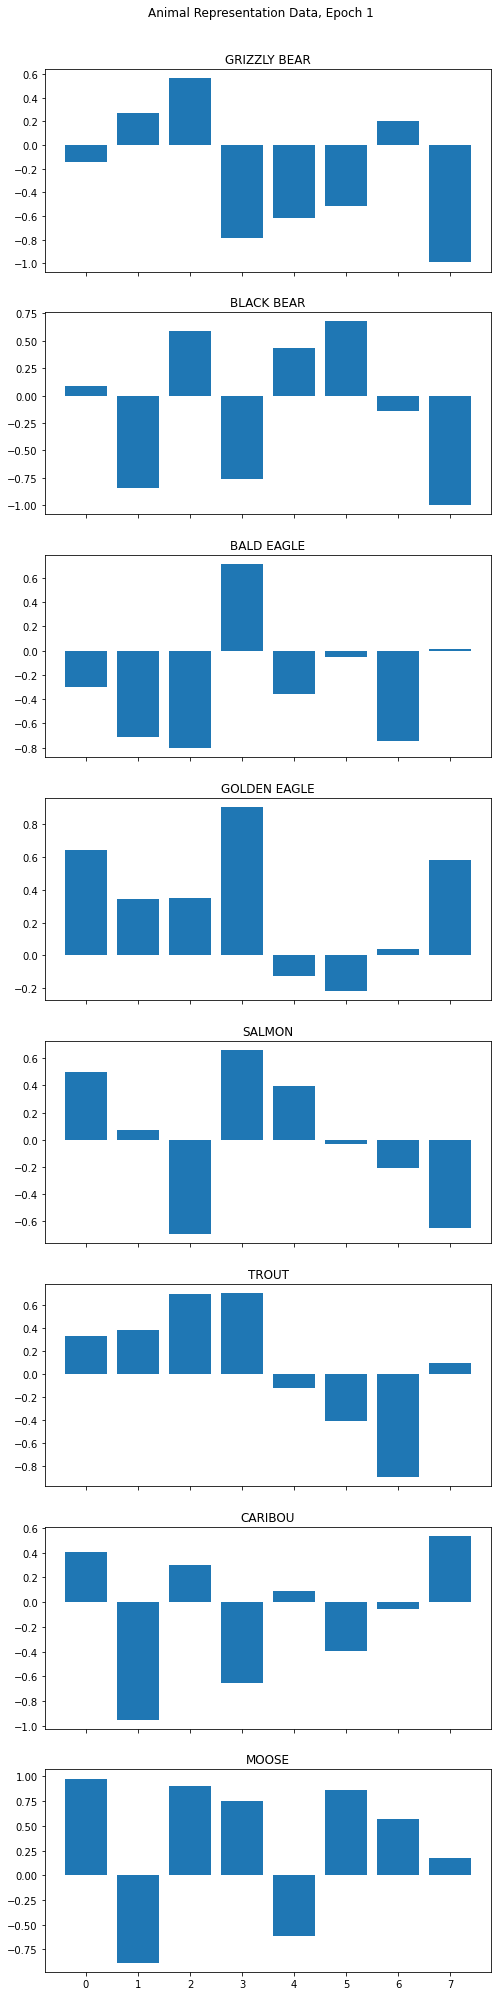

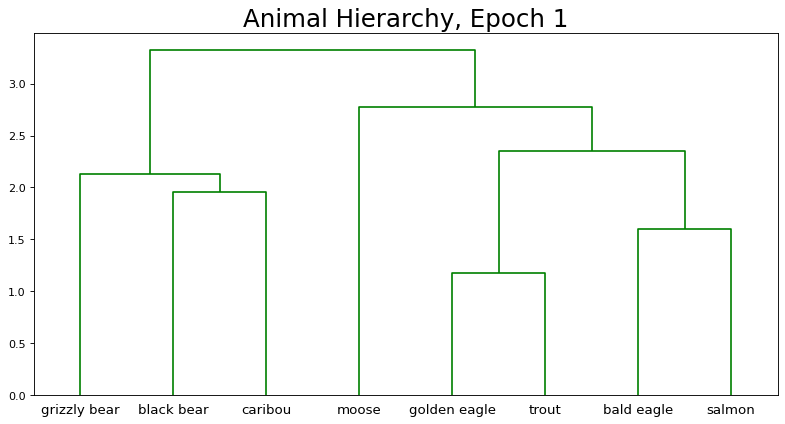

Train Epoch 175: 	Loss: 9.518231
Test: IS	Average loss = 5.968641
Test: ISA	Average loss = 16.137022
Test: CAN	Average loss = 8.646576
Test: HAS	Average loss = 7.296201


Train Epoch 350: 	Loss: 9.267510
Test: IS	Average loss = 5.803389
Test: ISA	Average loss = 15.547702
Test: CAN	Average loss = 8.558341
Test: HAS	Average loss = 7.141658


Train Epoch 525: 	Loss: 9.152537
Test: IS	Average loss = 5.709806
Test: ISA	Average loss = 15.298389
Test: CAN	Average loss = 8.519777
Test: HAS	Average loss = 7.075713


Train Epoch 700: 	Loss: 9.093113
Test: IS	Average loss = 5.655475
Test: ISA	Average loss = 15.195168
Test: CAN	Average loss = 8.509491
Test: HAS	Average loss = 7.006920


Train Epoch 875: 	Loss: 9.049685
Test: IS	Average loss = 5.560298
Test: ISA	Average loss = 15.154093
Test: CAN	Average loss = 8.505478
Test: HAS	Average loss = 6.974477




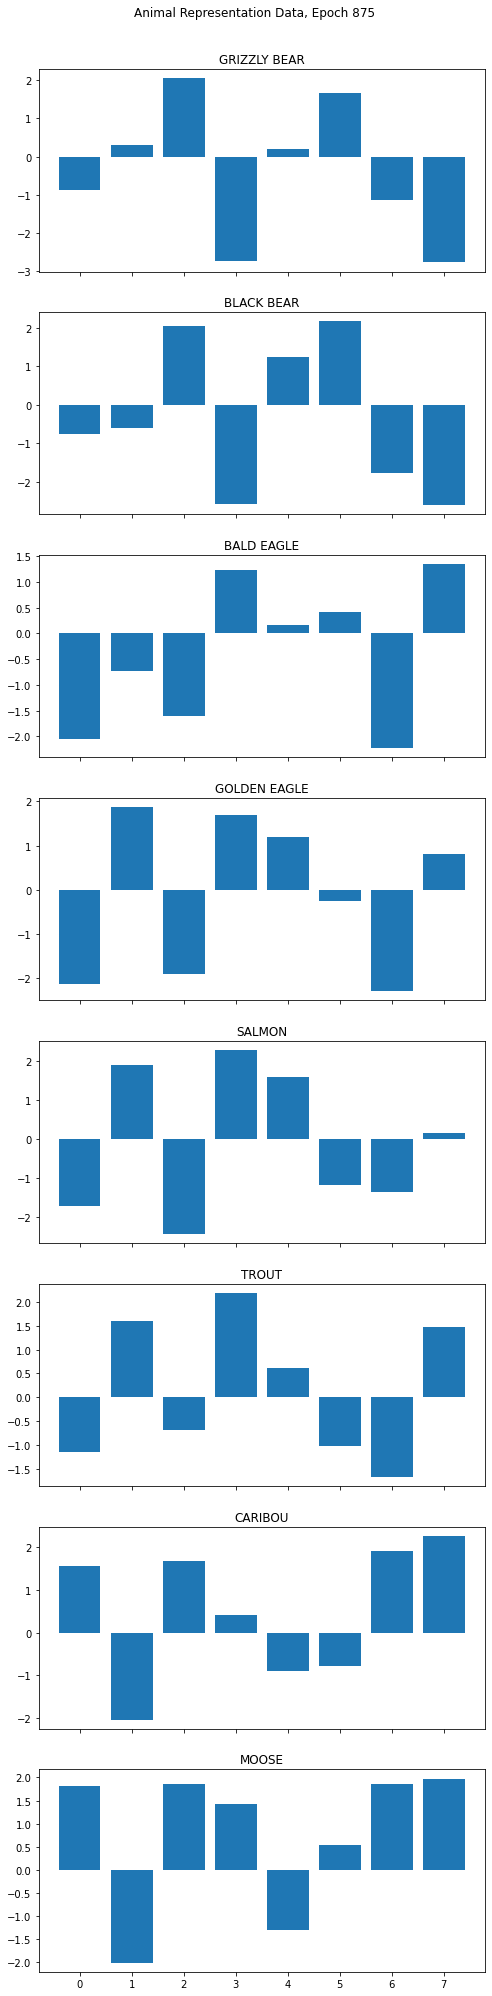

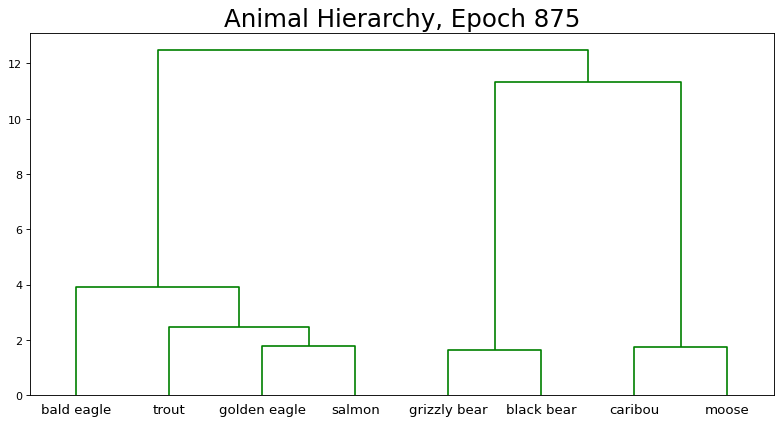

Train Epoch 1050: 	Loss: 9.022489
Test: IS	Average loss = 5.540813
Test: ISA	Average loss = 15.085133
Test: CAN	Average loss = 8.501766
Test: HAS	Average loss = 6.956929


Train Epoch 1225: 	Loss: 8.982657
Test: IS	Average loss = 5.456102
Test: ISA	Average loss = 15.030182
Test: CAN	Average loss = 8.498850
Test: HAS	Average loss = 6.940978


Train Epoch 1400: 	Loss: 8.936017
Test: IS	Average loss = 5.447076
Test: ISA	Average loss = 14.945390
Test: CAN	Average loss = 8.498628
Test: HAS	Average loss = 6.848827


Train Epoch 1575: 	Loss: 8.891316
Test: IS	Average loss = 5.441275
Test: ISA	Average loss = 14.786951
Test: CAN	Average loss = 8.497061
Test: HAS	Average loss = 6.837358


Train Epoch 1750: 	Loss: 8.876690
Test: IS	Average loss = 5.436689
Test: ISA	Average loss = 14.745967
Test: CAN	Average loss = 8.495170
Test: HAS	Average loss = 6.827543




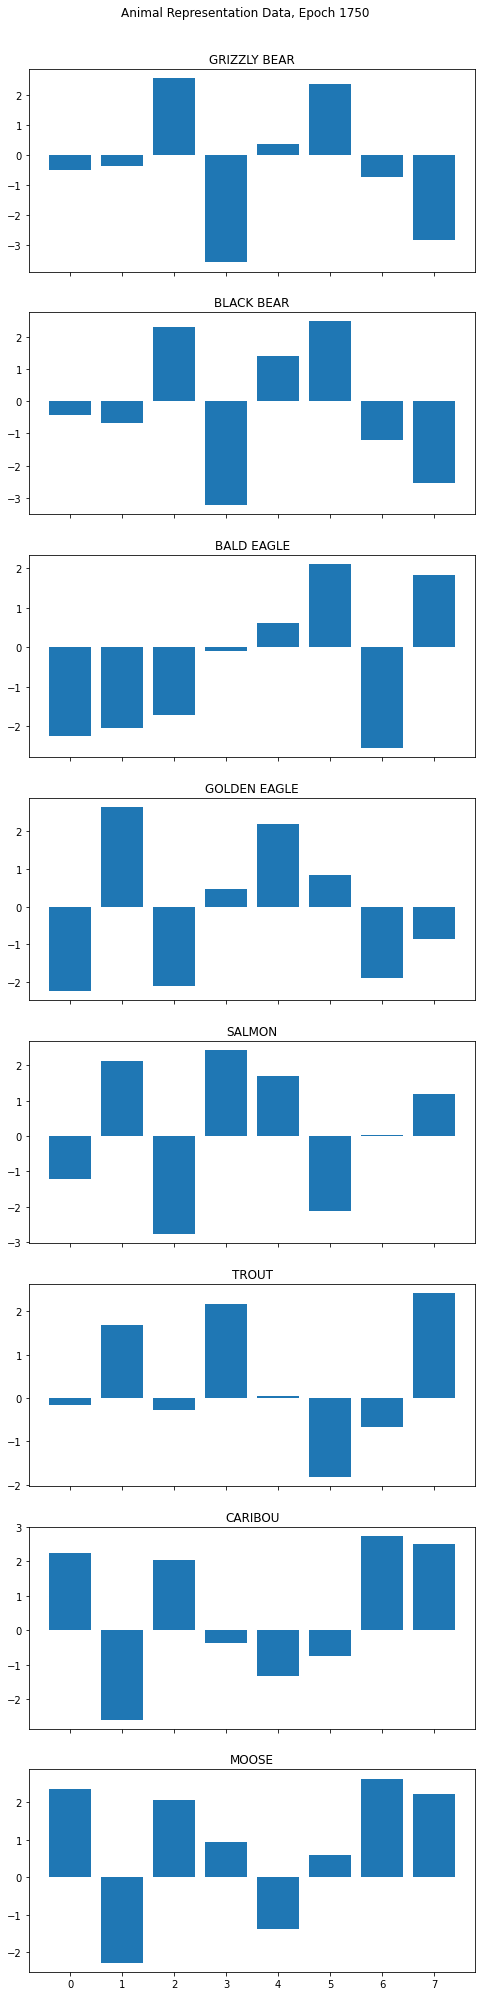

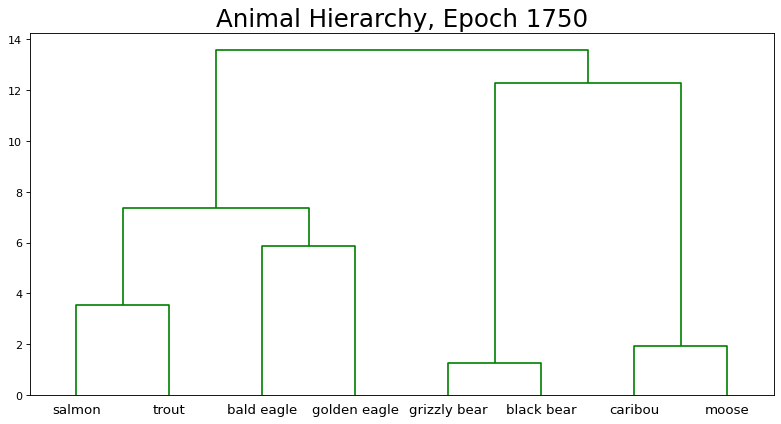

Train Epoch 1925: 	Loss: 8.868674
Test: IS	Average loss = 5.433614
Test: ISA	Average loss = 14.724852
Test: CAN	Average loss = 8.493776
Test: HAS	Average loss = 6.821573


Train Epoch 2100: 	Loss: 8.863346
Test: IS	Average loss = 5.431298
Test: ISA	Average loss = 14.711376
Test: CAN	Average loss = 8.492773
Test: HAS	Average loss = 6.817306


Train Epoch 2275: 	Loss: 8.859216
Test: IS	Average loss = 5.429432
Test: ISA	Average loss = 14.701952
Test: CAN	Average loss = 8.492069
Test: HAS	Average loss = 6.812883


Train Epoch 2450: 	Loss: 8.855461
Test: IS	Average loss = 5.427922
Test: ISA	Average loss = 14.695014
Test: CAN	Average loss = 8.491590
Test: HAS	Average loss = 6.806855


Train Epoch 2625: 	Loss: 8.852340
Test: IS	Average loss = 5.426765
Test: ISA	Average loss = 14.689412
Test: CAN	Average loss = 8.491108
Test: HAS	Average loss = 6.801694




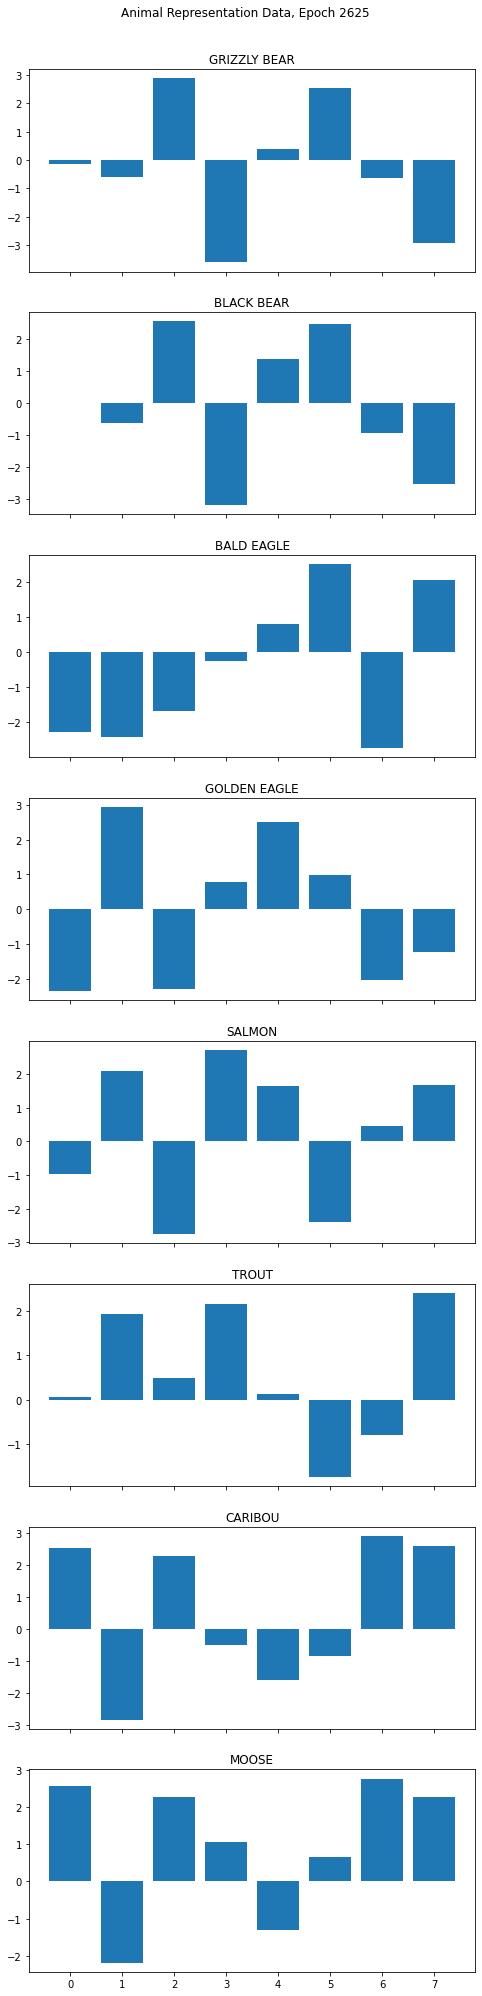

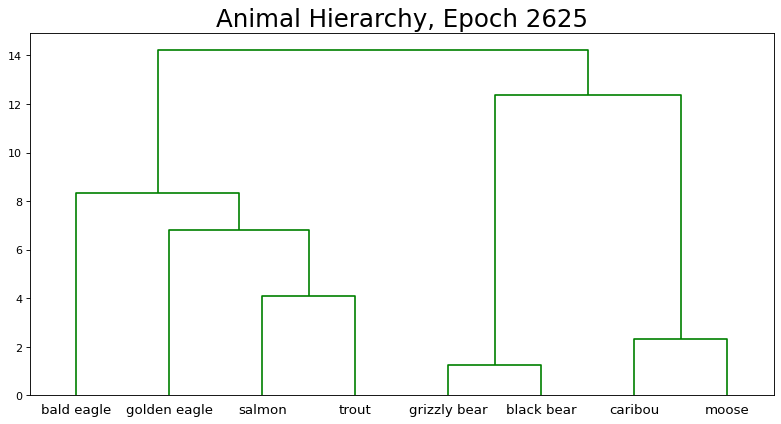

Train Epoch 2800: 	Loss: 8.849607
Test: IS	Average loss = 5.425876
Test: ISA	Average loss = 14.683647
Test: CAN	Average loss = 8.490646
Test: HAS	Average loss = 6.797904


Train Epoch 2975: 	Loss: 8.843710
Test: IS	Average loss = 5.425332
Test: ISA	Average loss = 14.663652
Test: CAN	Average loss = 8.490226
Test: HAS	Average loss = 6.795134


Train Epoch 3150: 	Loss: 8.838516
Test: IS	Average loss = 5.424558
Test: ISA	Average loss = 14.646709
Test: CAN	Average loss = 8.489907
Test: HAS	Average loss = 6.792534


Train Epoch 3325: 	Loss: 8.835760
Test: IS	Average loss = 5.423883
Test: ISA	Average loss = 14.638299
Test: CAN	Average loss = 8.489642
Test: HAS	Average loss = 6.790842


Train Epoch 3500: 	Loss: 8.833165
Test: IS	Average loss = 5.423429
Test: ISA	Average loss = 14.629635
Test: CAN	Average loss = 8.489449
Test: HAS	Average loss = 6.789741




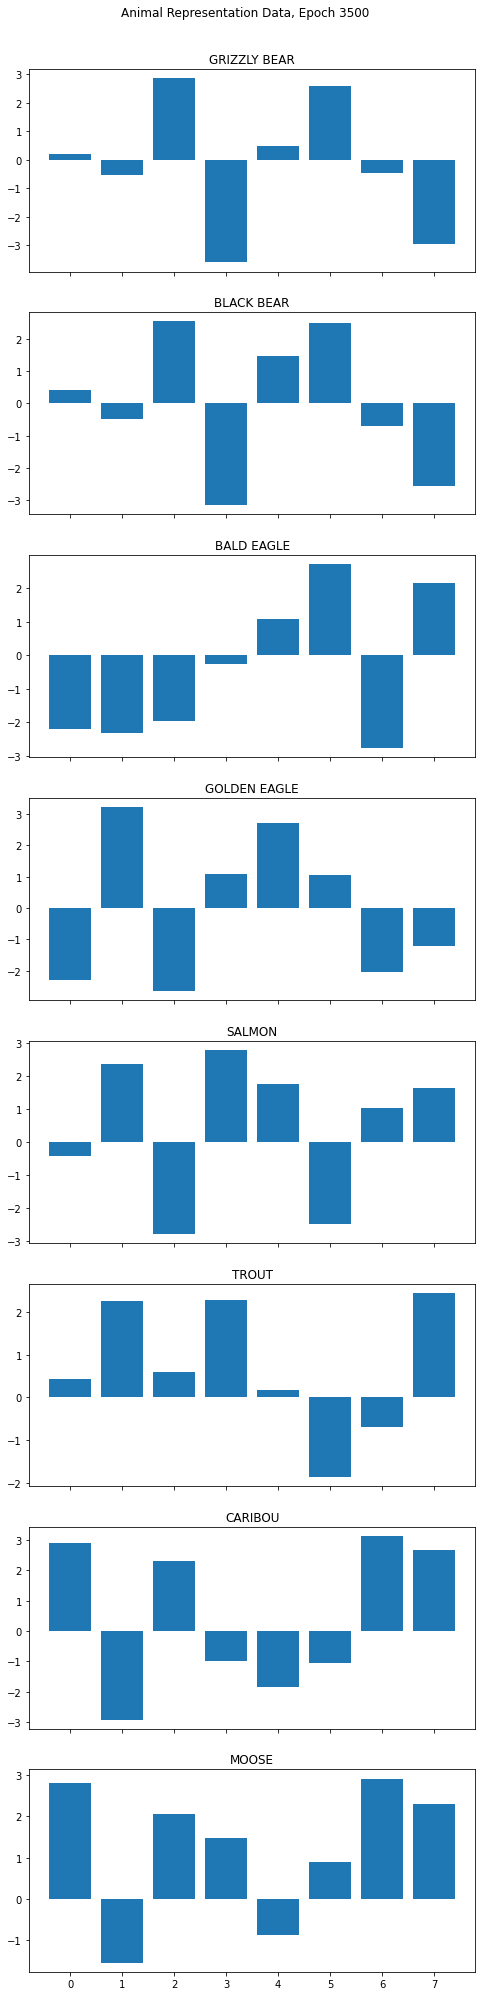

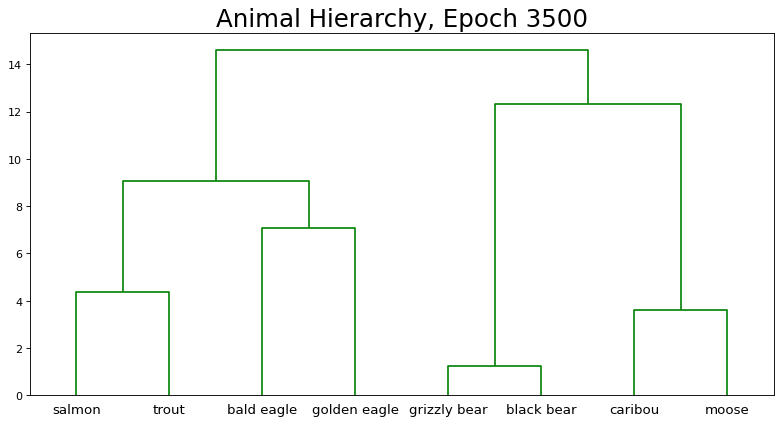

In [ ]:
# Commence training and testing
# Also print out representation graphs every 875 epochs
for epoch in range(1, num_epochs + 1):
  train(epoch)
  test(epoch)
  if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
    print("\n")
  if (epoch == 1) or (epoch % (num_epochs // 4) == 0):
    rep_data_list = create_rep_graphs(epoch)
    create_dendrogram(rep_data_list, epoch)

# Stage 4: Visualizations

In [ ]:
# Create function for making graphs comparing target vs. actual output
# z: specifying which relation's output should be graphed
def create_output_graphs(z):
  with torch.no_grad():
    print("Results for {}:".format(relations_list[z]))
    for index, (data, target) in enumerate(relation_DL_order[z]):
      x, y = data
      output = network(data)
      fig, axs = plt.subplots(figsize=(22,3))
      plt.tight_layout()
      labels = [label if i%2==0 else '\n'+label for i,label in enumerate(attributes_list)]
      axs.plot(labels, output.numpy()[0], 'o', label='output')
      axs.plot(labels, target.numpy()[0], 'o', label='target')
      axs.set_xlabel('\nattributes')
      axs.set_ylabel('value')
      axs.set_title(f"{animals_list[index]}, {relations_list[z]}")
      plt.legend();

Results for IS:


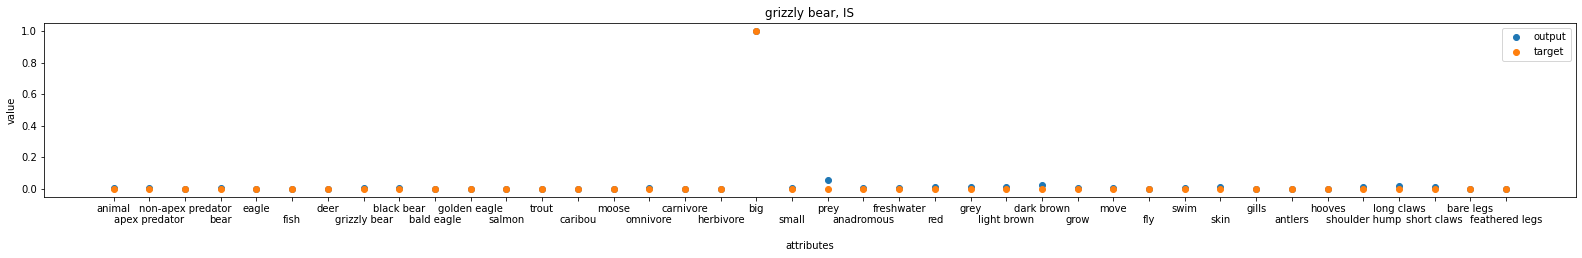

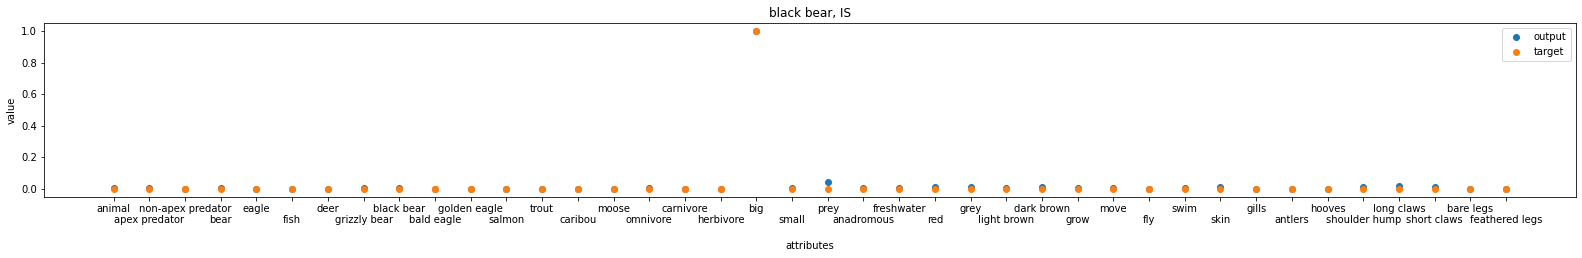

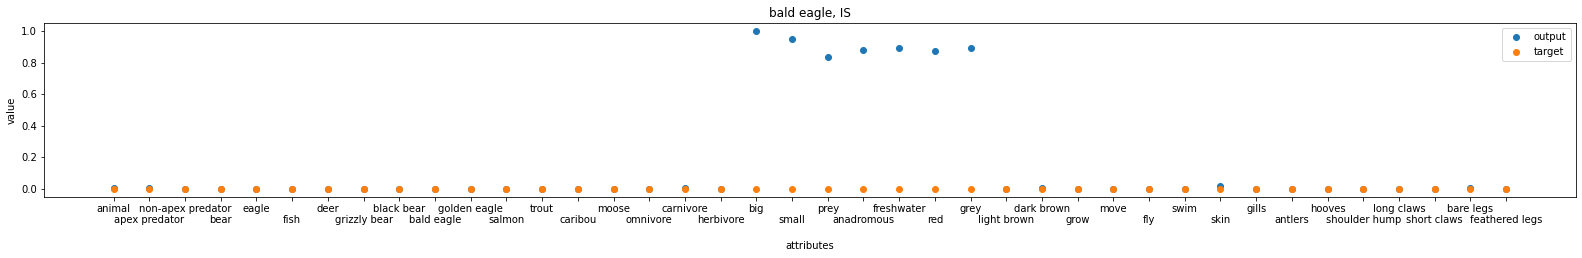

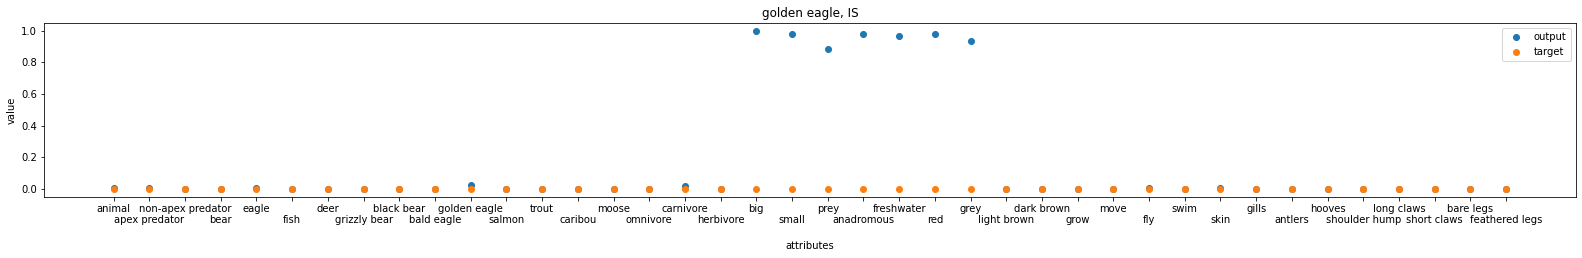

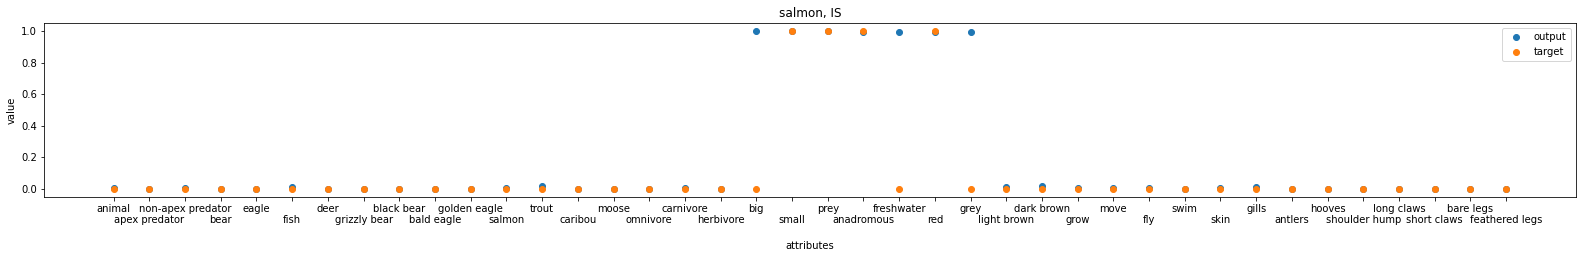

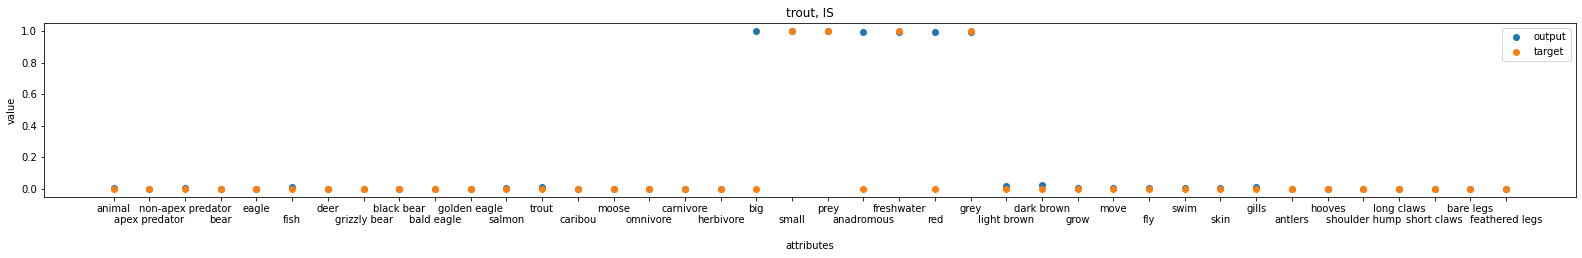

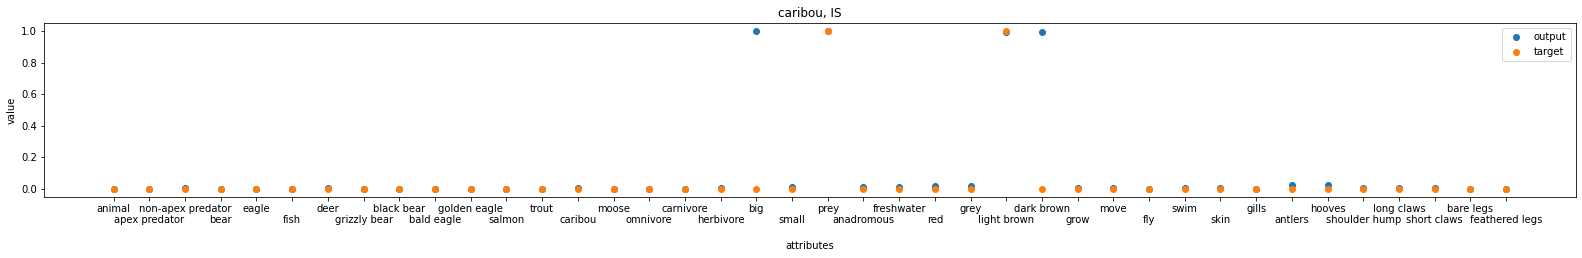

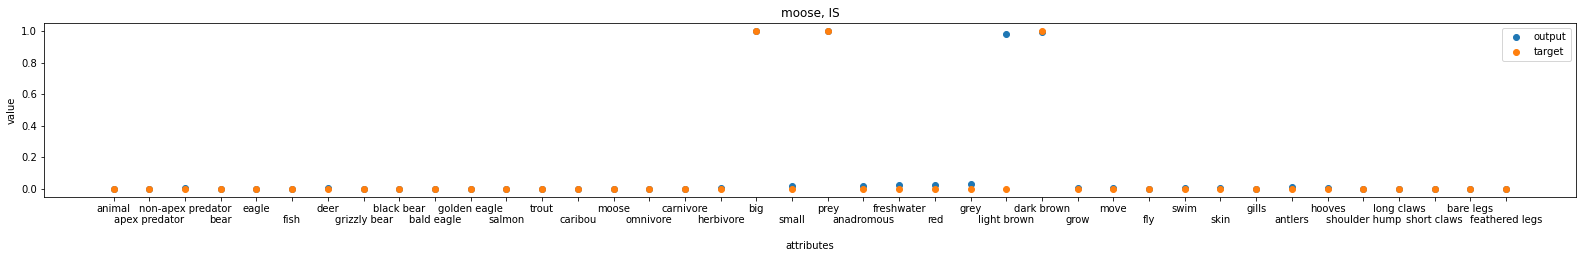

In [ ]:
# Display final results (IS) post-training
create_output_graphs(0)

Results for ISA:


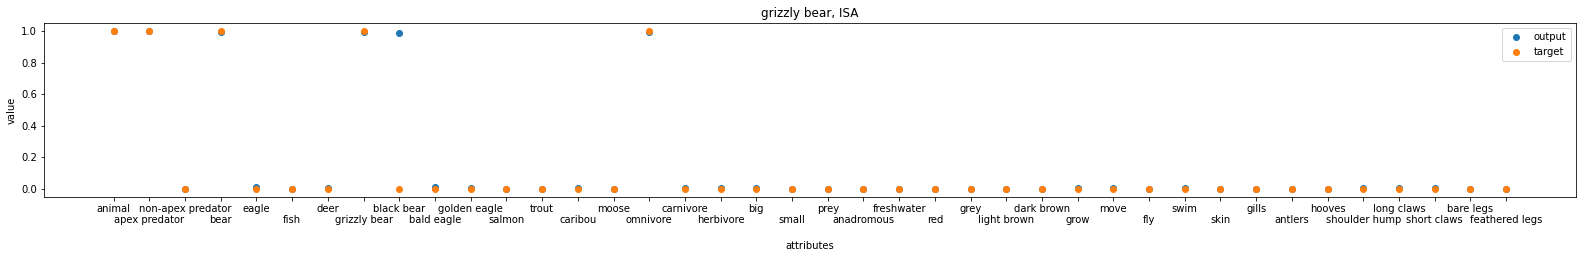

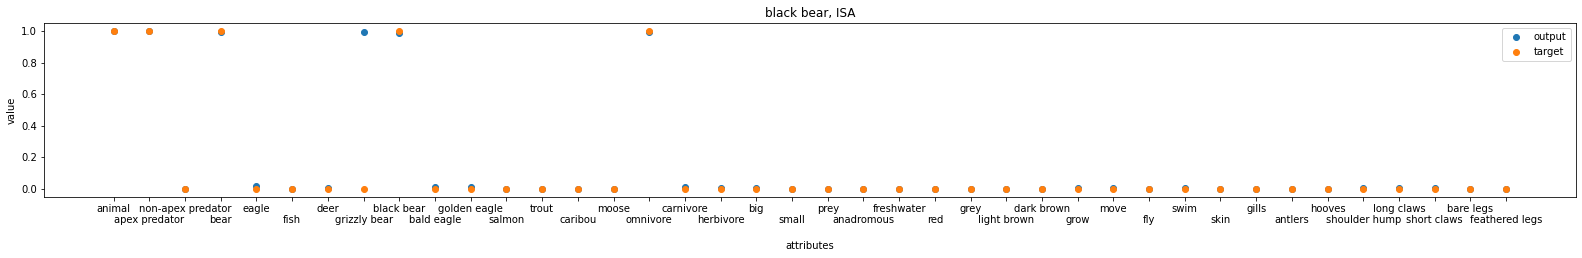

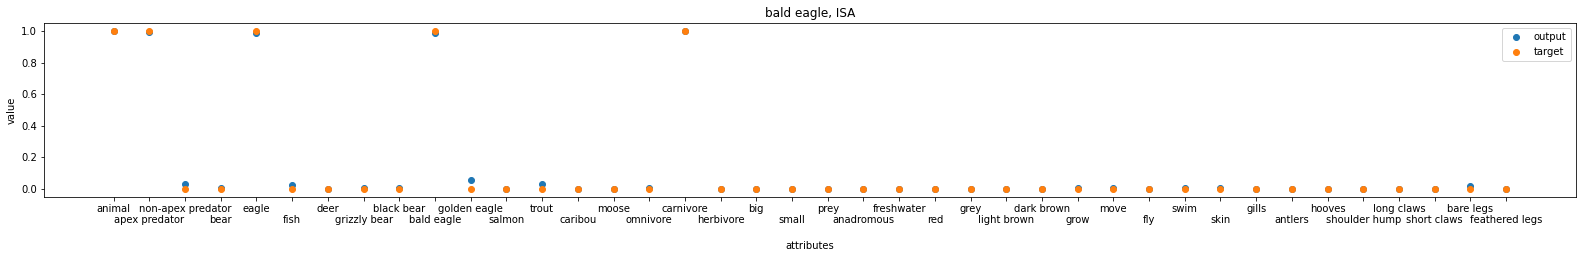

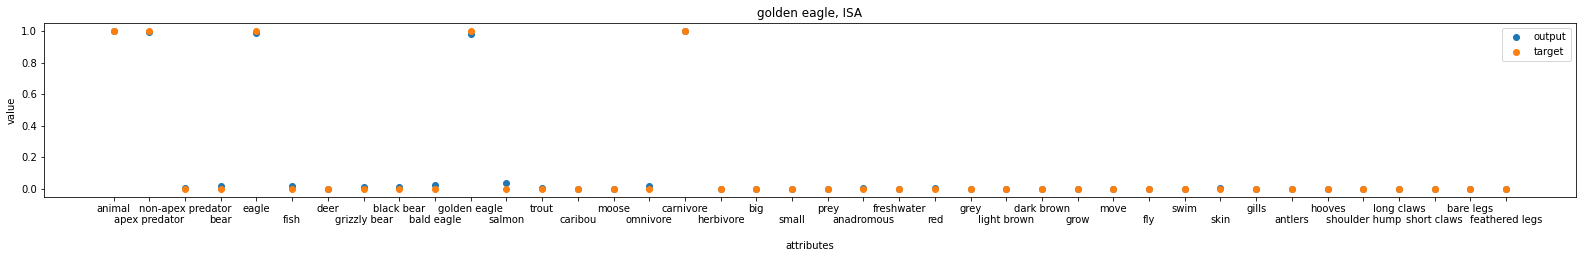

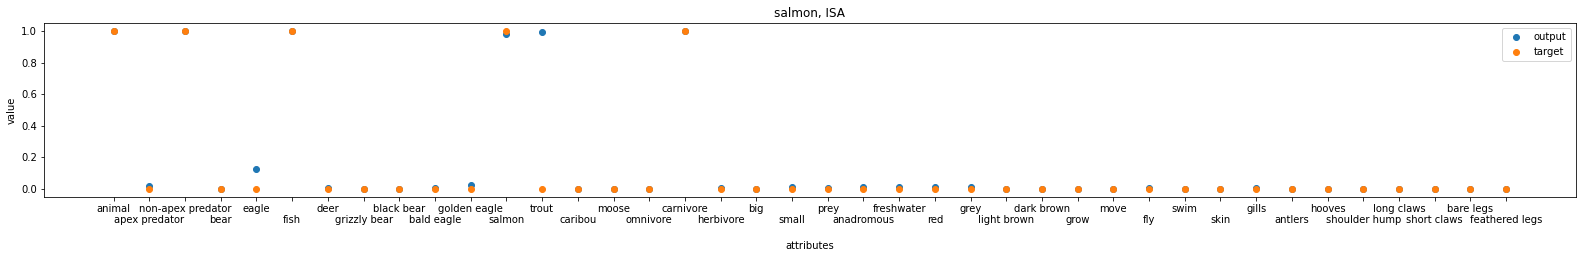

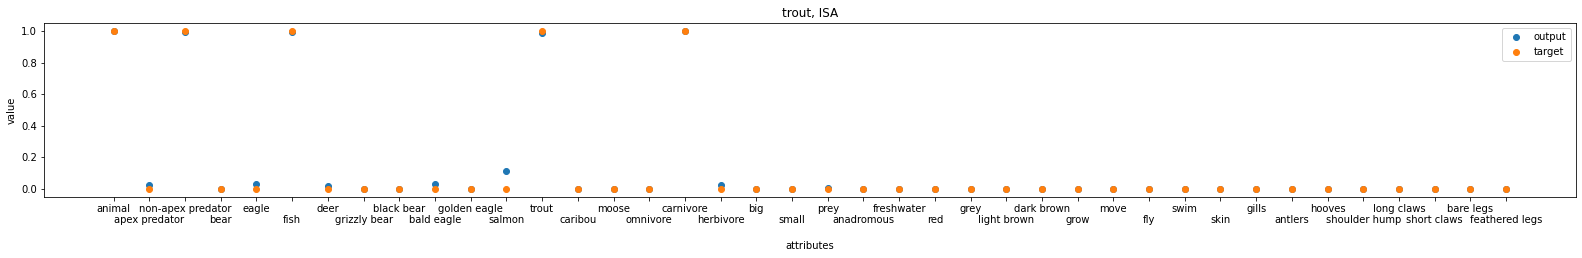

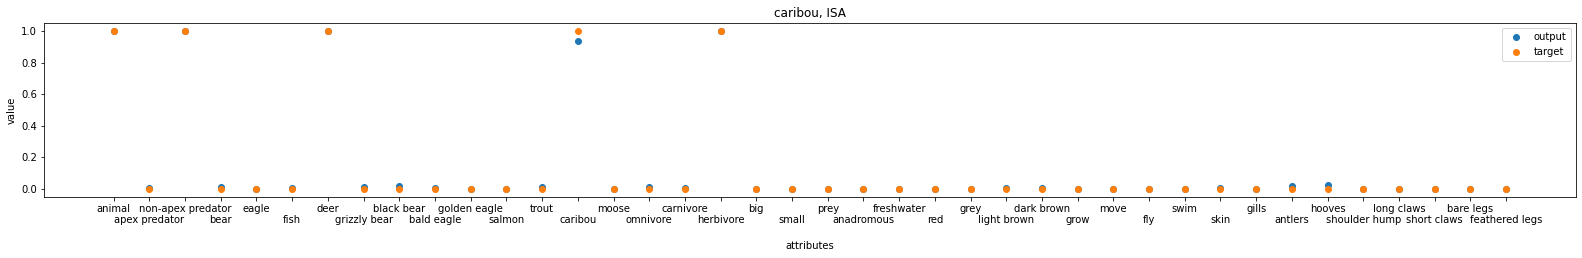

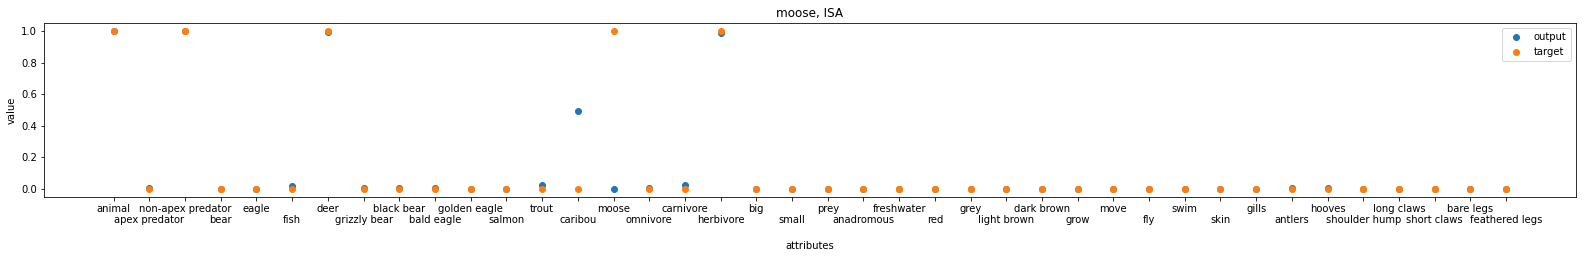

In [ ]:
# Display final results (ISA) post-training
create_output_graphs(1)

Results for CAN:


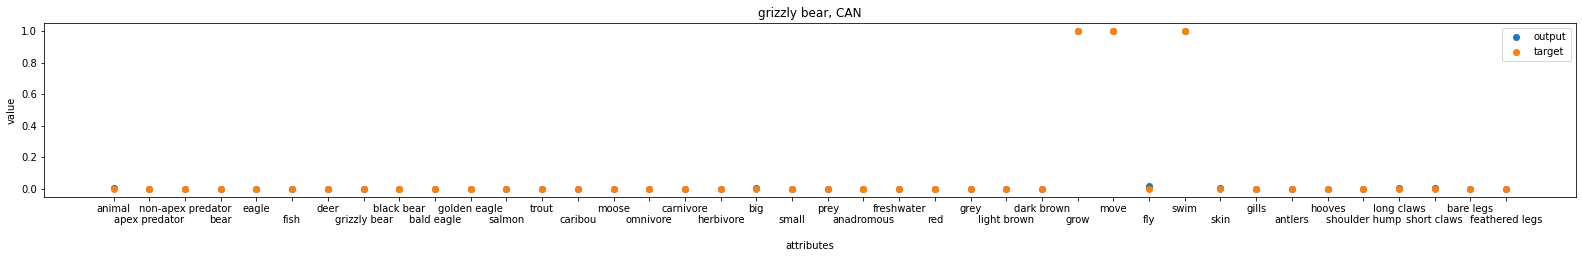

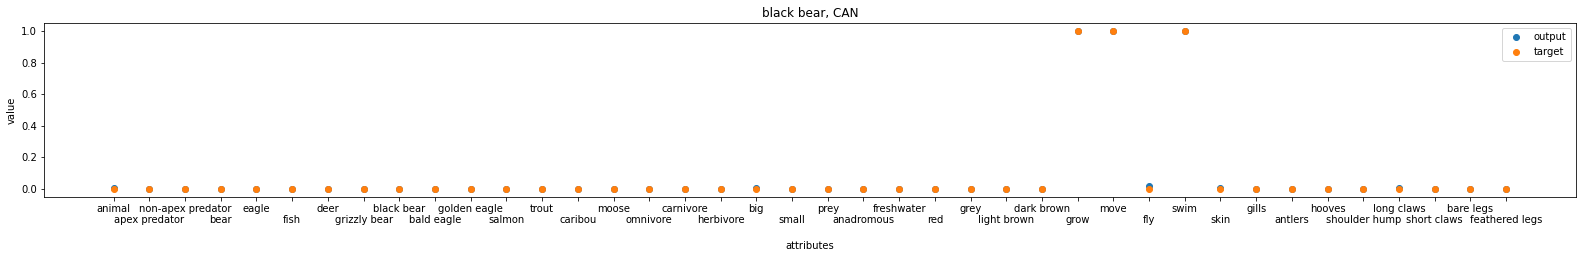

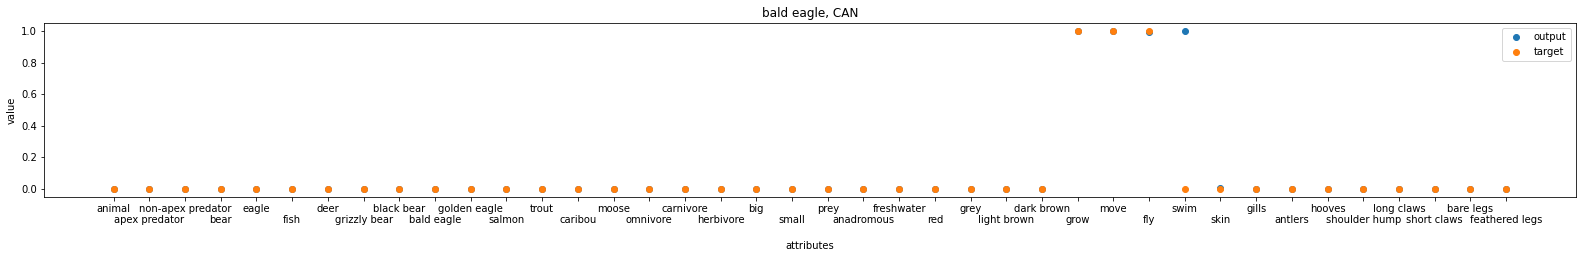

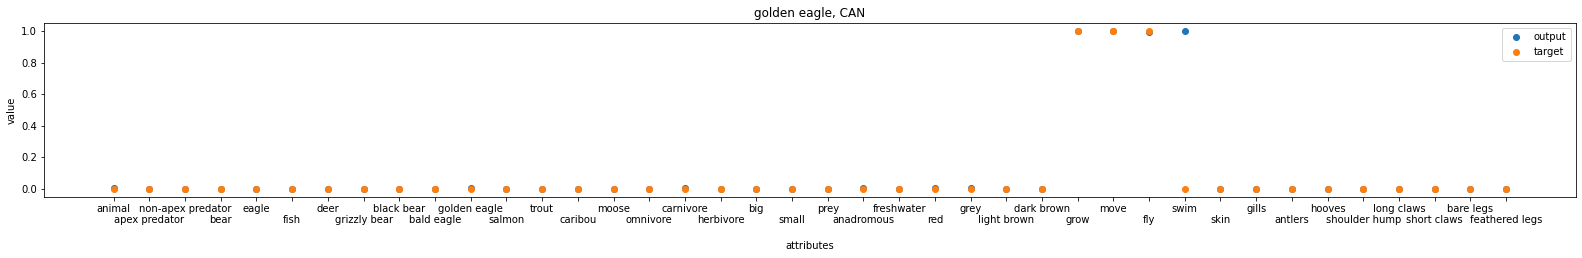

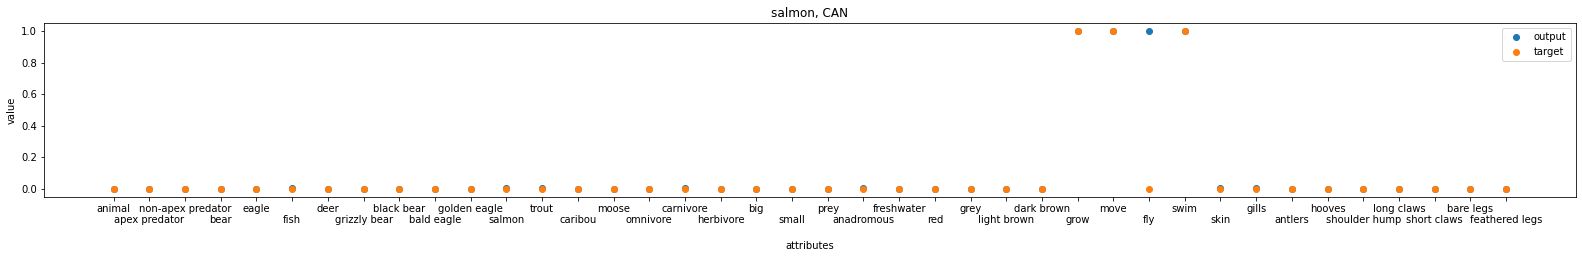

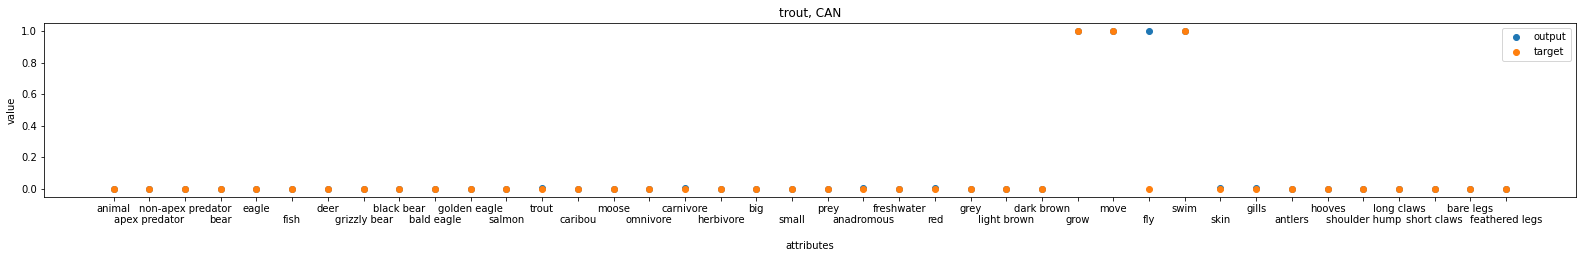

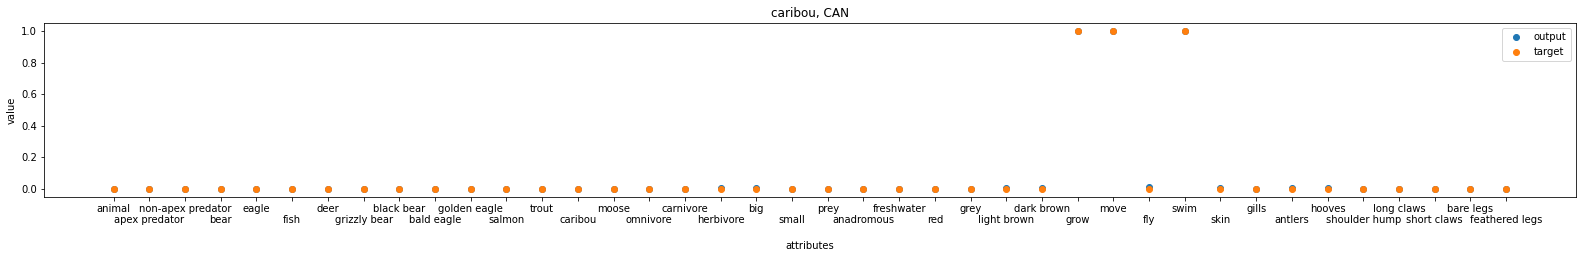

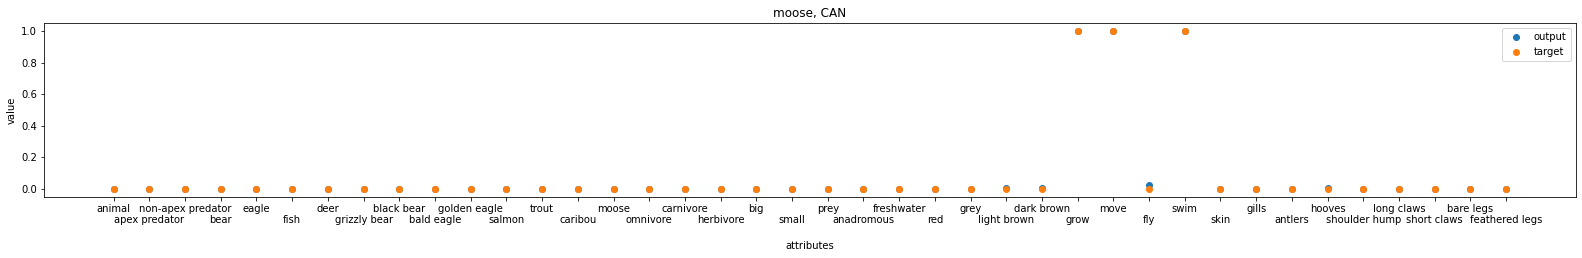

In [ ]:
# Display final results (CAN) post-training
create_output_graphs(2)

Results for HAS:


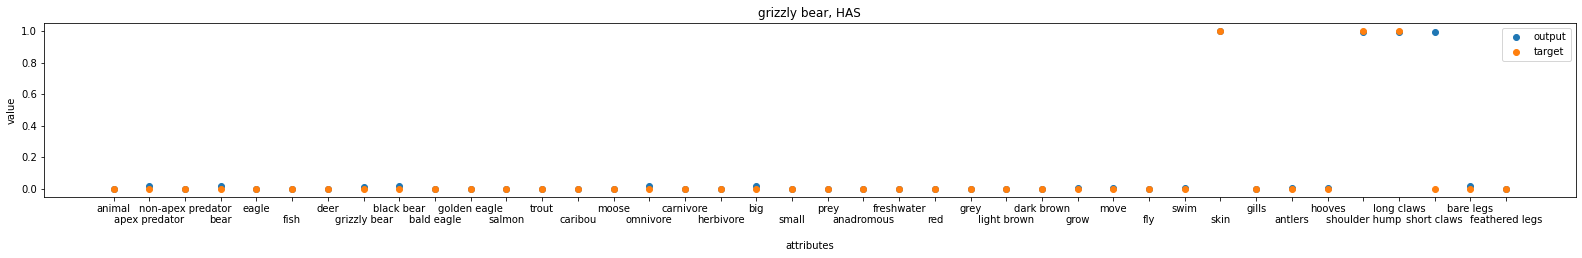

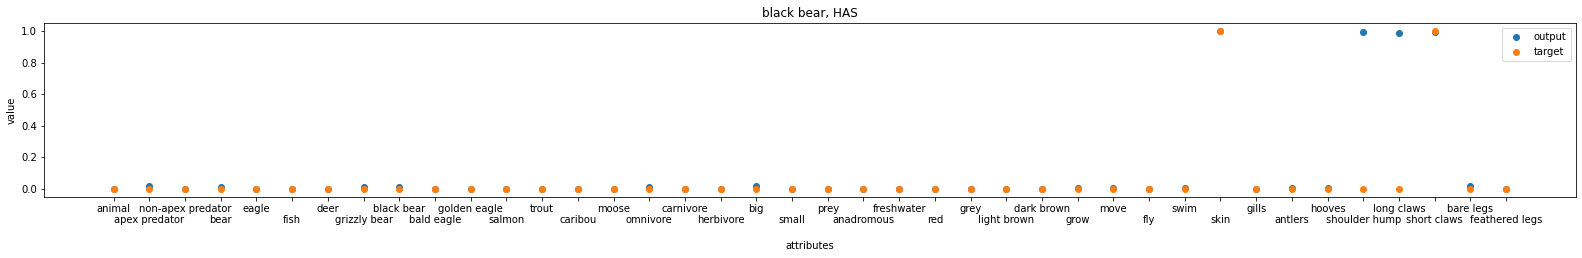

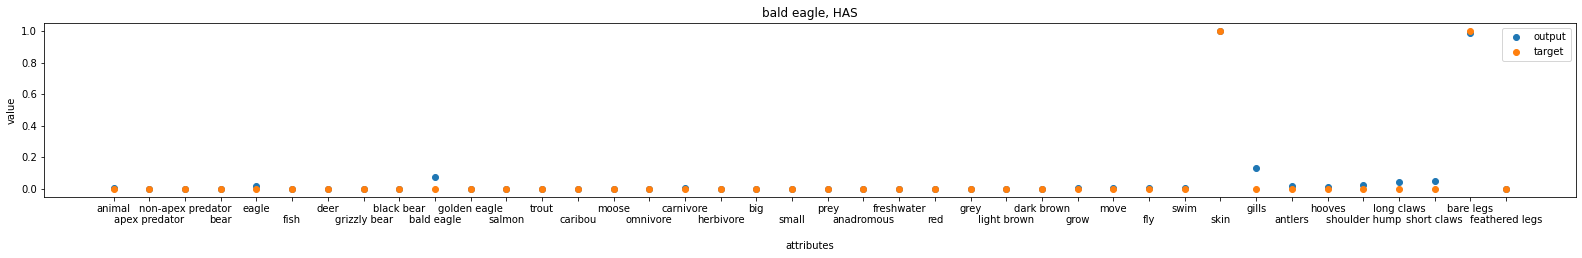

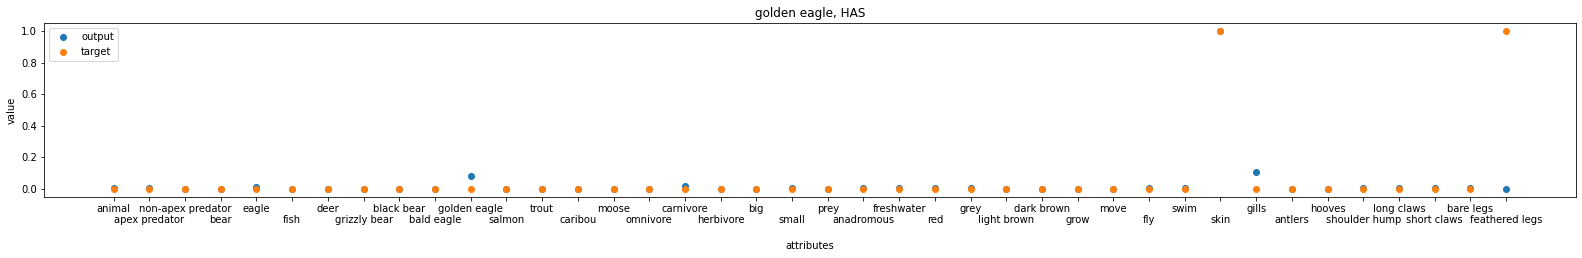

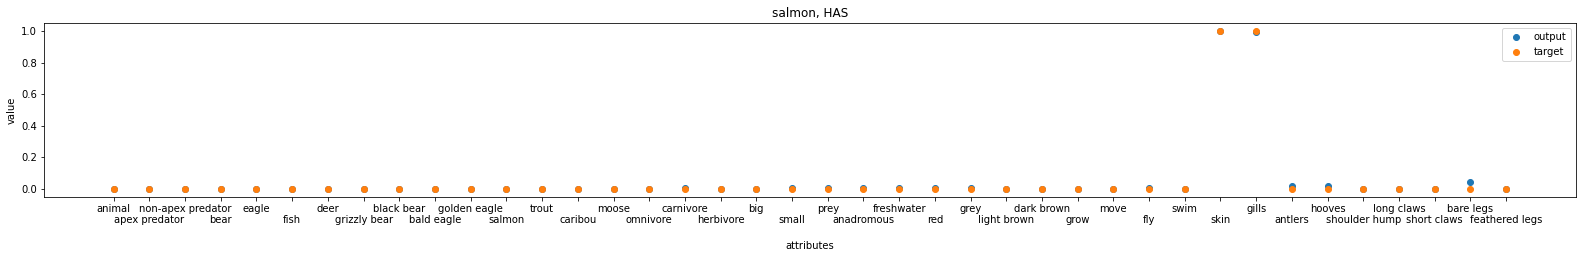

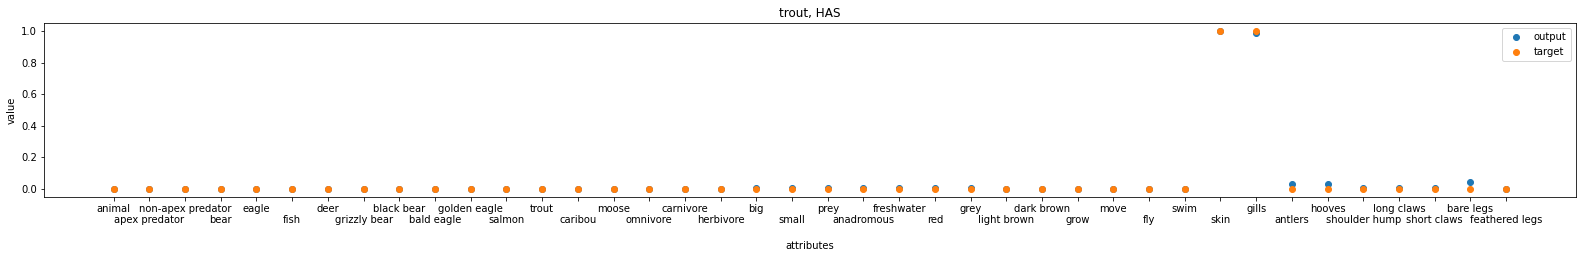

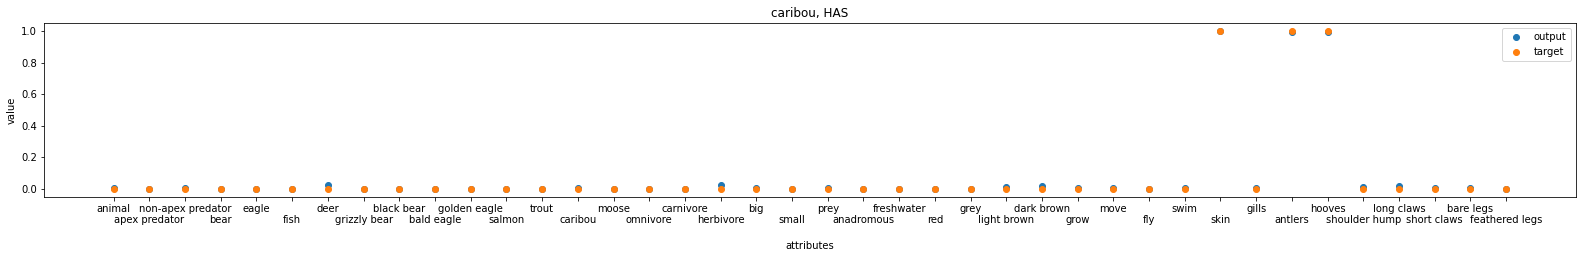

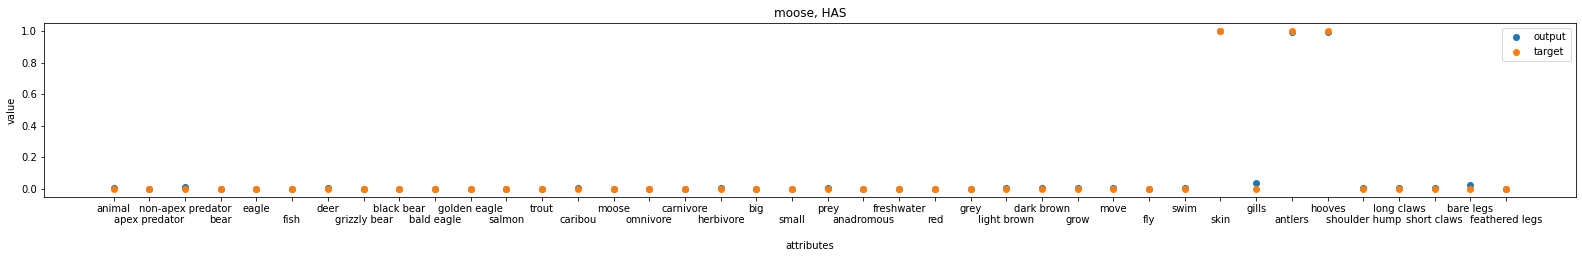

In [ ]:
# Display final results (HAS) post-training
create_output_graphs(3)